### Created on 2023
### @author: S.W

#### References
- https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko
- https://colab.research.google.com/drive/1v7OYMjLF1zkYUzcuCSUdpzUmIm_dCPPz#scrollTo=pZuOPwpc8dNa

-----

### 1. 학습에 필요한 라이브러리 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import time

### 2. MNIST 데이터 불러오기 & 이미지 데이터 전처리

#### 이미지 데이터 전처리

In [2]:
(train_images, train_labels_one_hot), (test_images, test_labels_one_hot) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5
# 마지막 layer의 활성화 함수로 sigmoid(0~1) 보다 tanh(-1~1)를 더 선호합니다.

print(train_images.shape)

(60000, 28, 28, 1)


In [3]:
num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels_one_hot, num_classes)
test_label_onehots  = tf.keras.utils.to_categorical(test_labels_one_hot, num_classes)

print(train_label_onehots.shape)

(60000, 10)


#### 훈련 데이터셋에서 이미지 추출 후 랜덤 시각화

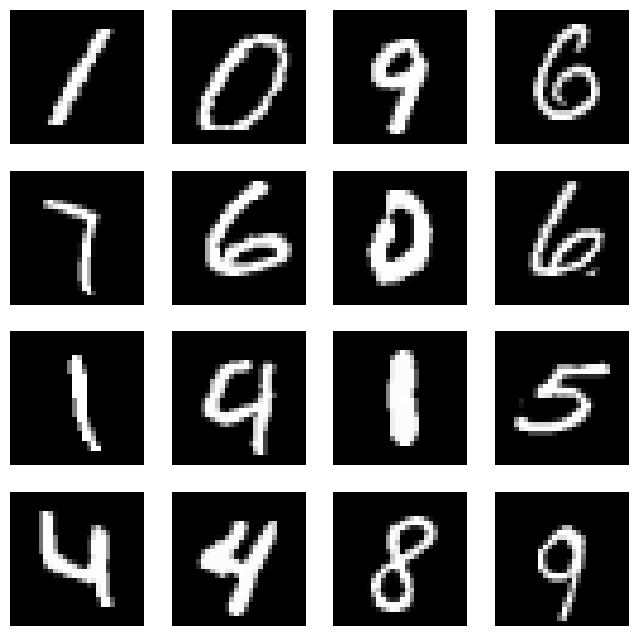

In [4]:
# 훈련 데이터셋에서 16개의 이미지 랜덤 선택
images = train_images[np.random.choice(train_images.shape[0], size=16, replace=False)]

# 이미지 시각화
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i, :, :, 0], cmap='gray')
    ax.axis('off')
plt.show()

#### 데이터를 batch_size 단위로 분할

In [5]:
BUFFER_SIZE = 60000 # buffer_size는 몇 개의 데이터를 버퍼에 담을지를 결정합니다.
BATCH_SIZE = 96
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_label_onehots)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 3. 모델 정의
#### 생성자 모델
- G 모델은 Noise로 부터 원래의 데이터를 생성해내는 모델입니다.
- Input : 100차원의 noise + label
- Output : Mnist 이미지 크기인 28*28

In [6]:
def create_generator():
    input_noise = keras.Input(shape=(100,))
    conditions = keras.Input(shape=(10,))

    x = layers.concatenate([input_noise, conditions])
    x = layers.Dense(7*7*128, use_bias=False, input_shape=(100,))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    output_img = x

    model = tf.keras.Model(inputs=[input_noise, conditions], outputs=output_img)
    return model

G = create_generator()
G.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 6272)         689920      concatenate[0][0]            

#### 판별자 모델
- D모델은 28*28 이미지가 실제 데이터인지 만들어진 데이터인지 판별합니다.
- Input : Mnist 이미지 (28*28)
- Output : 실제 데이터 일 확률 (0~1 사이의 값)

In [7]:
def create_discriminator():
    
    input_img = keras.Input(shape=(28,28,1))
    conditions = keras.Input(shape=(10,))

    x_c = layers.Dense(28*28)(conditions)
    x_c = layers.Reshape((28,28,1))(x_c)

    x = layers.concatenate([input_img, x_c])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    output = x


    model = tf.keras.Model(inputs=[input_img, conditions], outputs=output)
    return model

D = create_discriminator()
D.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          8624        input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           dense_1[0][0]                    
____________________________________________________________________________________________

#### 랜덤 값으로 테스트 해보기

tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)


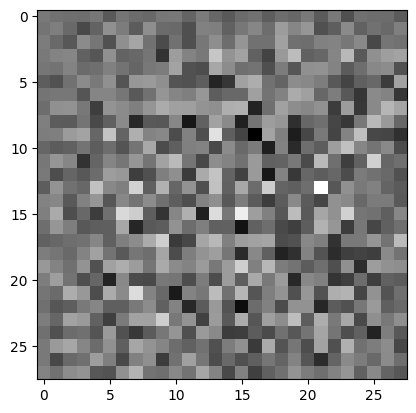

In [8]:
# 임의의 Noise를 G모델에 통과시키면 28*28 사이즈의 랜덤 이미지가 만들어집니다.
test_noise = tf.random.normal([1, 100])
test_conditions = tf.one_hot([i % 10 for i in range(1)], depth=10)
print(test_conditions)

fake_image_test = G([test_noise, test_conditions], training=False)

plt.imshow(fake_image_test[0], cmap='gray')

In [9]:
# 그리고 G모델에서 만들어진 이미지를 D모델에 통과시키면 확률이 나오게 됩니다.
decision = D([fake_image_test, test_conditions], training=False)
print(decision)

tf.Tensor([[0.00472955]], shape=(1, 1), dtype=float32)


### 4. 모델 학습 파라미터 설정

In [10]:
EPOCHS = 50
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

# 최적화 방법: Adam
G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
# 손실함수: 이진 교차 엔트로피
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    # 판별자 손실함수
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def G_loss(fake_output):
    # 생성자 손실함수
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 5. 모델 학습

#### 훈련 데이터셋 학습 함수 정의

In [12]:
# 아래의 train_step 함수에는 @tf.function이라는 데코레이터가 사용됩니다.
# 특정한 상황일때 함수를 'compile' 하여 속도가 빨라진다고 대략적으로 이해하시면 됩니다!

# 아래의 train_step 함수에는 @tf.function이라는 데코레이터가 사용됩니다.
@tf.function(experimental_relax_shapes=True)
def train_step(real_images, real_conditions):  
  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])
  
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
        # tf.GradientTape()를 사용하여 생성자(G)와 판별자(D) 모델을 학습시키는데 필요한 연산들을 기록
        # gen_tape과 dsc_tape는 각각 생성자와 판별자 모델의 손실 함수에 대한 기울기(gradient)를 계산하기 위해 사용
        fake_images = G([noises, real_conditions], training=True)
    
        real_output = D([real_images, real_conditions], training=True)
        fake_output = D([fake_images, real_conditions], training=True)

        gen_loss = G_loss(fake_output)
        dsc_loss = D_loss(real_output, fake_output)
        
    # 손실 함수값을 이용하여 gen_tape.gradient 함수와 dsc_tape.gradient 함수를 사용하여 각 모델의 기울기(gradient)를 계산
    gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
    dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
    
    # G_optimizer.apply_gradients와 D_optimizer.apply_gradients 함수를 사용하여 기울기를 이용하여 각 모델의 가중치를 업데이트
    G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables)) 
    D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))

#### 테스트 데이터셋 학습 함수 정의

In [13]:
def test_step(real_images, real_conditions):  
    noises = tf.random.normal([BATCH_SIZE, noise_dim])
  
    fake_images = G([noises, real_conditions], training=False)

    real_output = D([real_images, real_conditions], training=False)
    fake_output = D([fake_images, real_conditions], training=False)    

    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)
  
    print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())
    
    return gen_loss.numpy(), dsc_loss.numpy()

#### 손실함수 그래프 함수 정의

In [14]:
def plot_loss(losses) :
    plt.figure(figsize=(10,10))

    plt.plot(losses[0], label="Generator losses")
    plt.plot(losses[1], label="Discriminator losses")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend()
    plt.show()

In [15]:
# 학습 함수
def train(dataset, epochs):
    gen_losses = []
    dsc_losses = []

    for epoch in range(epochs):
        start = time.time()
    
        for i, image_batch in enumerate(dataset):
            train_step(image_batch[0],image_batch[1])
            if i == 0:
                gen_loss, dsc_loss = test_step(image_batch[0],image_batch[1])
                gen_losses.append(gen_loss)
                dsc_losses.append(dsc_loss)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start)) 

    losses = [gen_losses, dsc_losses]
    plot_loss(losses)

Generator loss: 0.69327897 Discriminator loss: 1.3265542
Time for epoch 1 is 9.637443780899048 sec
Generator loss: 0.32943666 Discriminator loss: 2.0293262
Time for epoch 2 is 8.939075708389282 sec
Generator loss: 1.2479388 Discriminator loss: 0.83677393
Time for epoch 3 is 8.965094327926636 sec
Generator loss: 0.7009754 Discriminator loss: 1.425134
Time for epoch 4 is 8.988028049468994 sec
Generator loss: 1.0130469 Discriminator loss: 1.0240049
Time for epoch 5 is 9.014619827270508 sec
Generator loss: 0.79758835 Discriminator loss: 1.2041993
Time for epoch 6 is 9.046490907669067 sec
Generator loss: 0.89734656 Discriminator loss: 1.2476269
Time for epoch 7 is 9.113639831542969 sec
Generator loss: 1.0498883 Discriminator loss: 1.1150981
Time for epoch 8 is 9.019378185272217 sec
Generator loss: 0.7337537 Discriminator loss: 1.320361
Time for epoch 9 is 9.069695472717285 sec
Generator loss: 0.8656904 Discriminator loss: 1.1094712
Time for epoch 10 is 8.960353136062622 sec
Generator loss: 

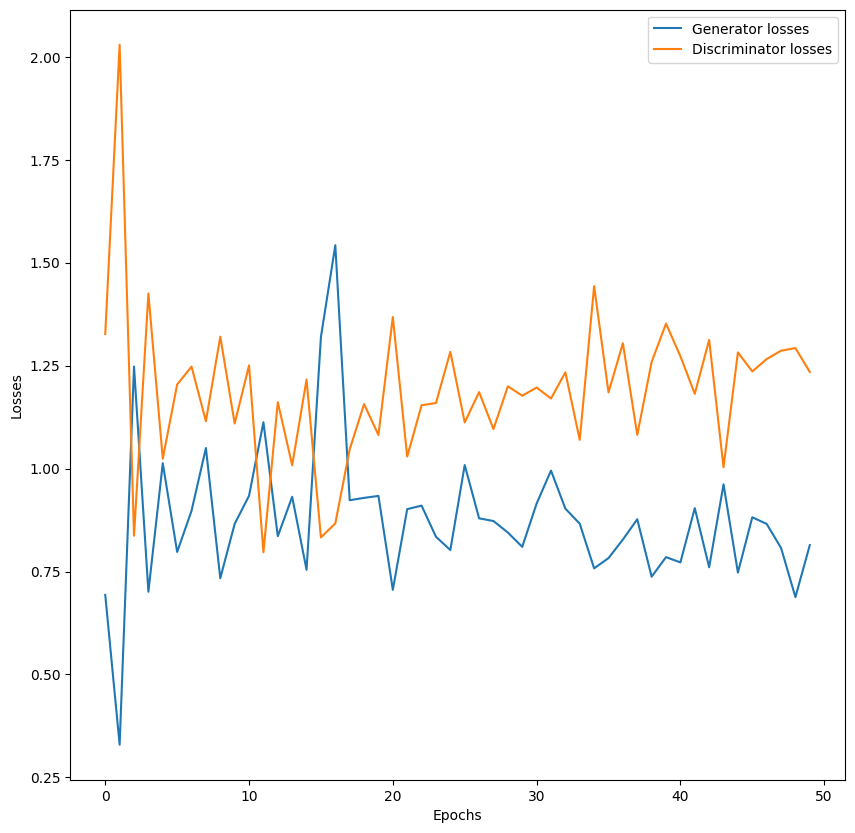

In [16]:
train(train_dataset, EPOCHS)

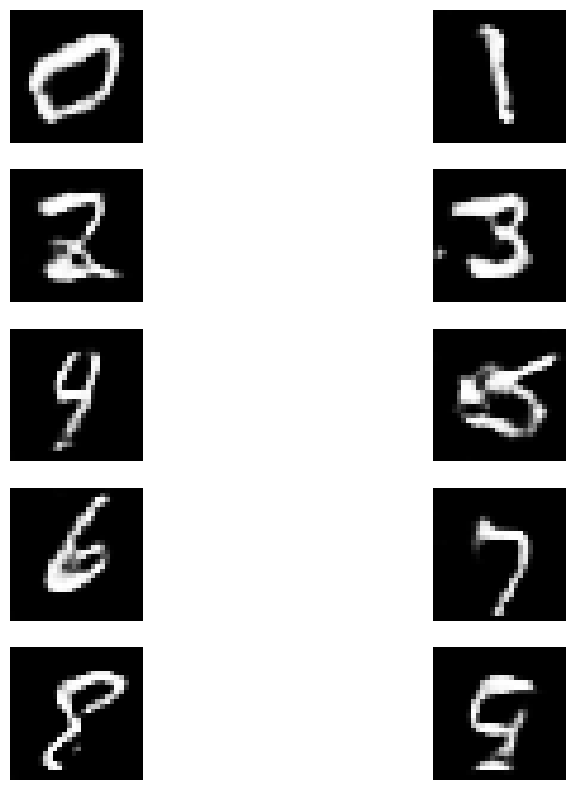

In [18]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

noises = tf.random.normal([10, 100])
labels = np.array([
                [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
                ], dtype=np.float32)
generated_image = G([noises, labels], training=False)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0][:,:,0], cmap='gray')
axes[0,1].imshow(generated_image[1][:,:,0], cmap='gray')
axes[1,0].imshow(generated_image[2][:,:,0], cmap='gray')
axes[1,1].imshow(generated_image[3][:,:,0], cmap='gray')
axes[2,0].imshow(generated_image[4][:,:,0], cmap='gray')
axes[2,1].imshow(generated_image[5][:,:,0], cmap='gray')
axes[3,0].imshow(generated_image[6][:,:,0], cmap='gray')
axes[3,1].imshow(generated_image[7][:,:,0], cmap='gray')
axes[4,0].imshow(generated_image[8][:,:,0], cmap='gray')
axes[4,1].imshow(generated_image[9][:,:,0], cmap='gray')


plt.show()